### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from models import *
import shap
from captum.attr import IntegratedGradients, ShapleyValueSampling
import matplotlib.pyplot as plt


# Import data

In [2]:
# read data
df = pd.read_csv('data/data.csv')

# Prepare data for training

In [3]:
feature_cols = [col for col in df.columns if col not in ['timestamp','ticker','target']]
df_norm = df.copy(deep=True)
df_norm = df_norm.dropna(subset=feature_cols) # should not drop any rows

df_norm['timestamp'] = pd.to_datetime(df_norm['timestamp'])

# drop data from 2025
df_norm = df_norm[df_norm['timestamp'] < '2025-01-01']

# normalize inputs
X_values = df_norm[feature_cols].values.astype('float32')

# # simple normalization: subtract mean, divide std
# X_mean, X_std = X_values.mean(axis=0), X_values.std(axis=0)
# X_values = (X_values - X_mean) / (X_std + 1e-8) # adding a small epsilon to avoid division by zero

y_values = df_norm['target'].values.astype('float32')

periods = { 
            # '20' : '2020-01-01', 
            # '21' : '2021-01-01', 
            # '22' : '2022-01-01',  
            '23' : '2023-01-01' 
            } # year used for validation i.e. 2020-01-01 will use 2001-2019 for training and 2020 for validation

X_train, y_train = {}, {}
X_val, y_val = {}, {}
X_test, y_test = {}, {}
X_scalars, y_scalars = {}, {}


for name, period in periods.items():
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    assert (df_norm.loc[tr_mask, 'timestamp'].max() <
        df_norm.loc[va_mask, 'timestamp'].min()), "train leaks into val"

    assert (df_norm.loc[va_mask, 'timestamp'].max() <
            df_norm.loc[te_mask, 'timestamp'].min()), "val leaks into test"

    X_tr, y_tr = X_values[tr_mask], y_values[tr_mask]
    X_va, y_va = X_values[va_mask], y_values[va_mask]
    X_te, y_te = X_values[te_mask], y_values[te_mask]

    X_scalars[name], y_scalars[name] = StandardScaler(), StandardScaler()

    X_scalars[name].fit(X_tr)
    X_train[name] = X_scalars[name].transform(X_tr)
    X_val[name] = X_scalars[name].transform(X_va)
    X_test[name] = X_scalars[name].transform(X_te)

    # ignoring the target normalization
    # y_scalars[name].fit(y_tr.reshape(-1, 1))
    # y_train[name] = y_scalars[name].transform(y_tr.reshape(-1, 1))
    # y_val[name] = y_scalars[name].transform(y_va.reshape(-1, 1))
    # y_test[name] = y_scalars[name].transform(y_te.reshape(-1, 1))

    y_train[name] = y_tr.reshape(-1, 1)
    y_val[name] = y_va.reshape(-1, 1)
    y_test[name] = y_te.reshape(-1, 1)


In [4]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
# input_dim = x_train_mlp.shape[1]
hidden_depth = 2 # only hidden, excluding in- and output layers
hidden_width = 32 # int for all being equal width; list for different widths
learning_rate = 3e-4 # increased from 1e-3 as we have full batching
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity


# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 0.0 # 1e-3 currently 0 
lambda_l2 = 0.0 # 1e-3 0 because of weight decay


weight_decay = 1e-3
dropout = 0.2

# general parmeters
patience = 250
print_freq = 250
epochs = 500
batch_size = 4096 # 8192 # 16384 # 2^1X adjust to your memory


Using device: mps


# Train the model

In [5]:
best_models = {}
history = {}
models = {}

for name, period in periods.items():
    np.random.seed(42)
    torch.manual_seed(42)
    print(f"Training model for year '{name}...")
    input_dim = X_train[name].shape[1]
    models[name] = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
    optimizer = torch.optim.AdamW(models[name].parameters(), weight_decay=weight_decay, lr=learning_rate)
    train = MLPdataset(X_train[name], y_train[name])
    val = MLPdataset(X_val[name], y_val[name])
    best_models[name], history[name] = train_mlp(train,          
                                                val,
                                                models[name],
                                                criterion,
                                                epochs,
                                                patience,
                                                print_freq,
                                                device,
                                                optimizer,
                                                lambda_l1=lambda_l1,
                                                lambda_l2=lambda_l2,
                                                batch_size=batch_size,
                                                shuffle_train=True,
                                                shuffle_val=False,
                                                save_path=f'models/mlp_y{name}_l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                )

Training model for year '23...
Epoch 250/500  - Train Loss: 2.60234E-02  - Val Loss: 1.33475E-02
Early stopping at epoch 431
Best val loss: 1.30718E-02
Model saved to models/mlp_y23_l10.0_l20.001_drop0.2_lr0.0003_w32_d2.pth


In [6]:
# best_models = {}
# history = {}
# models = {}

# for name, period in periods.items():
#     np.random.seed(42)
#     torch.manual_seed(42)
#     print(f"Training model for period {name}...")
#     input_dim = X_train[name].shape[1]
#     models[name] = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
#     optimizer = torch.optim.AdamW(models[name].parameters(), weight_decay=weight_decay, lr=learning_rate)
#     train = MLPdataset(X_train[name], y_train[name])
#     val = MLPdataset(X_val[name], y_val[name])
#     best_models[name], history[name] = train_mlp(train,          
#                                                  val,
#                                                  models[name],
#                                                  criterion,
#                                                  epochs,
#                                                  patience,
#                                                  print_freq,
#                                                  device,
#                                                  optimizer,
#                                                  lambda_l1=lambda_l1,
#                                                  lambda_l2=lambda_l2,
#                                                  batch_size=batch_size,
#                                                  shuffle_train=True,
#                                                  shuffle_val=False,
#                                                  save_path=f'models/mlp_model_{name}.pth')

# Graph the model

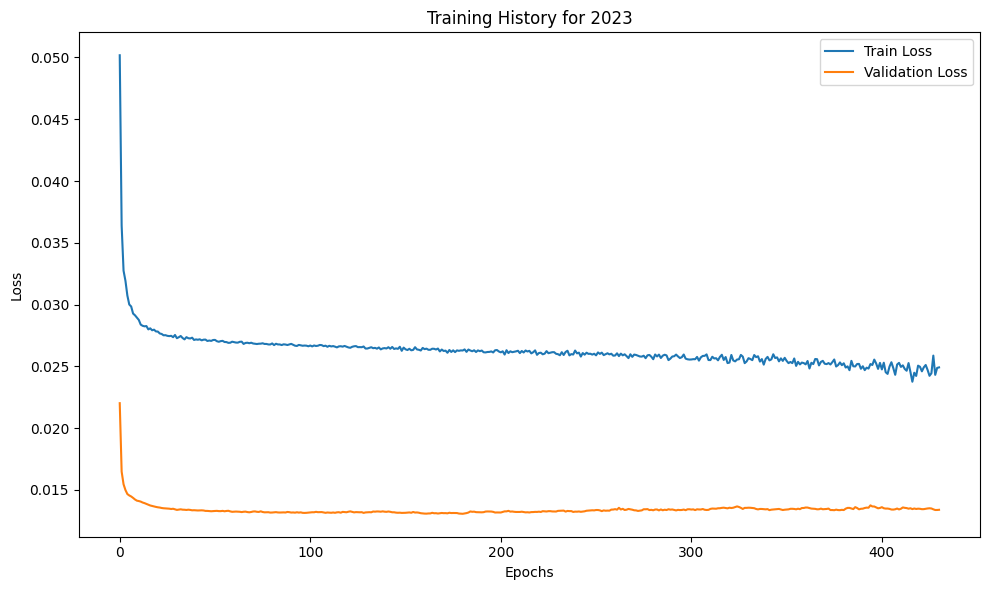

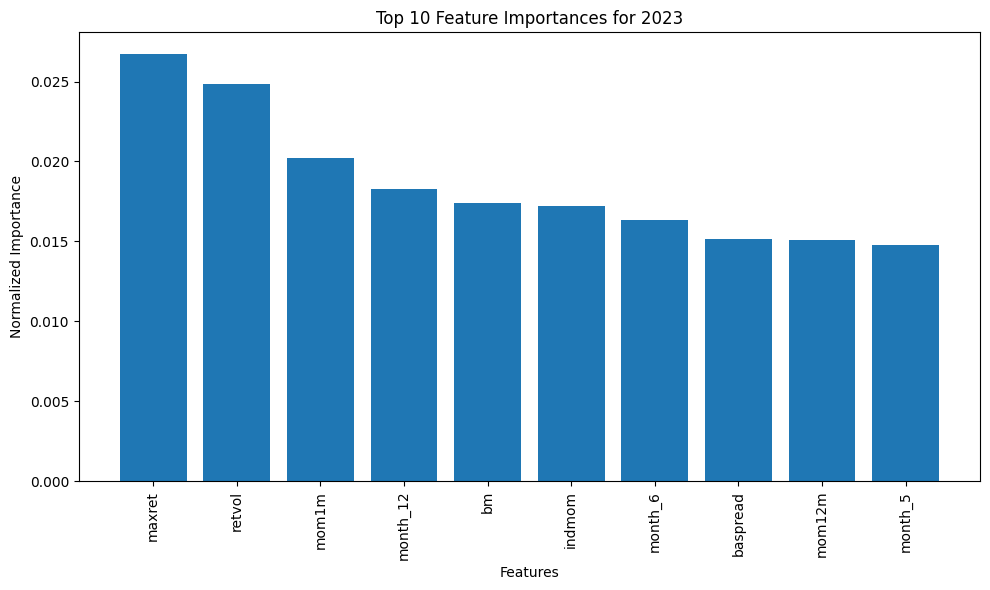

In [7]:
top_n = 10  # how many features to show
feature_cols = [col for col in df.columns if col not in ['timestamp','ticker','target']]
for name, period in periods.items():
    # plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history[name]['train_loss'], label='Train Loss')
    plt.plot(history[name]['val_loss'],   label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training History for 20{name}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # plot importance in best model
    best_model = best_models[name].eval()
    val_loader = DataLoader(MLPdataset(X_val[name], y_val[name]), batch_size=batch_size, shuffle=False)


    # --- COMMENTED OUT: drop boolean vars if you want ---
    # bool_vars = [c for c in feature_cols if c.startswith('NACE_') or c.startswith('month_')]
    # feature_cols = [c for c in feature_cols if c not in bool_vars]
    # ------------------------------------------------------

    # accumulate gradients
    n_features = len(feature_cols)
    feature_importance = torch.zeros(n_features).to(device)
    n_samples = 0

    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        batch_X.requires_grad_()
        outputs = best_model(batch_X)
        output_sum = outputs.sum()
        
        best_model.zero_grad()
        output_sum.backward()
        
        feature_importance += batch_X.grad.abs().sum(dim=0)
        n_samples += batch_X.size(0)

    feature_importance /= n_samples
    importance_np = feature_importance.cpu().detach().numpy()
    importance_norm = importance_np / importance_np.sum()

    # sort descending
    sorted_idx        = np.argsort(importance_norm)[::-1]
    sorted_importance = importance_norm[sorted_idx]
    sorted_features   = [feature_cols[i] for i in sorted_idx]

    # keep only top_n
    sorted_features = sorted_features[:top_n]
    sorted_importance = sorted_importance[:top_n]

    # bar chart of top features
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_features)), sorted_importance, align='center')
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Normalized Importance')
    plt.title(f'Top {top_n} Feature Importances for 20{name}')
    plt.tight_layout()
    plt.show()
    plt.close()

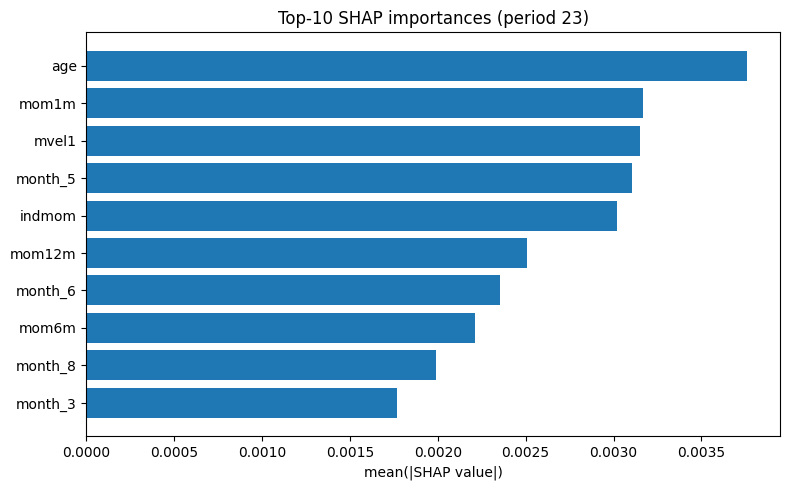

In [108]:
# --- CONFIG & RELOAD ---
period = "23"
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device('cpu')
load_path = (
    f"models/mlp_y{period}"
    f"_l1{lambda_l1}"
    f"_l2{weight_decay}"
    f"_drop{dropout}"
    f"_lr{learning_rate}"
    f"_w{hidden_width}"
    f"_d{hidden_depth}.pth"
)
model = MLPModel(
    input_dim  = X_train[period].shape[1],
    depth      = hidden_depth,
    width      = hidden_width,
    dropout    = dropout,
    activation = activation_fun,
).to(device)
model.load_state_dict(torch.load(load_path, map_location=device))
model.eval()

# --- DATA TENSORS ---
X_tr_t = torch.tensor(X_train[period], dtype=torch.float32, device=device)
X_val_t = torch.tensor(X_val[period],   dtype=torch.float32, device=device)

# small background sample for SHAP
bg_size = min(100000, X_tr_t.shape[0])
bg_idx  = torch.randperm(X_tr_t.shape[0], device=device)[:bg_size]
background = X_tr_t[bg_idx]   # shape (bg_size, n_features)

# --- SHAP GradientExplainer ---
explainer = shap.GradientExplainer(model, background)

raw_shap = explainer.shap_values(X_val_t)

# unwrap it: if it's a list, grab the 0th element
if isinstance(raw_shap, list) and len(raw_shap) == 1:
    raw_shap = raw_shap[0]

# raw_shap is now an ndarray of shape (n_val, n_features)
# convert to torch to aggregate
shap_t = torch.from_numpy(raw_shap).to(device)
global_shap = shap_t.abs().mean(dim=0).cpu().numpy().reshape(-1)   # shape (n_features,)

# --- Build DataFrame & Plot Top-10 ---
df_imp = pd.DataFrame({
    "feature": feature_cols,
    "shap_importance": global_shap
})
df_top10 = df_imp.nlargest(10, "shap_importance").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,5))
y_pos = np.arange(len(df_top10))
ax.barh(y_pos, df_top10["shap_importance"])
ax.set_yticks(y_pos)
ax.set_yticklabels(df_top10["feature"])
ax.invert_yaxis()
ax.set_xlabel("mean(|SHAP value|)")
ax.set_title(f"Top-10 SHAP importances (period {period})")
plt.tight_layout()
plt.show()


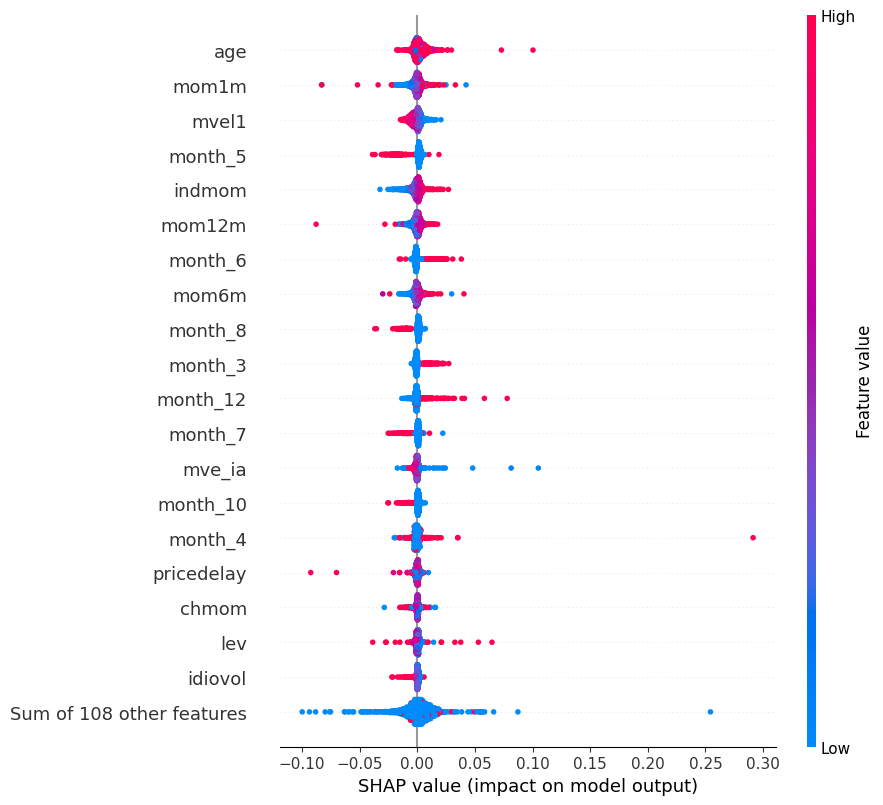

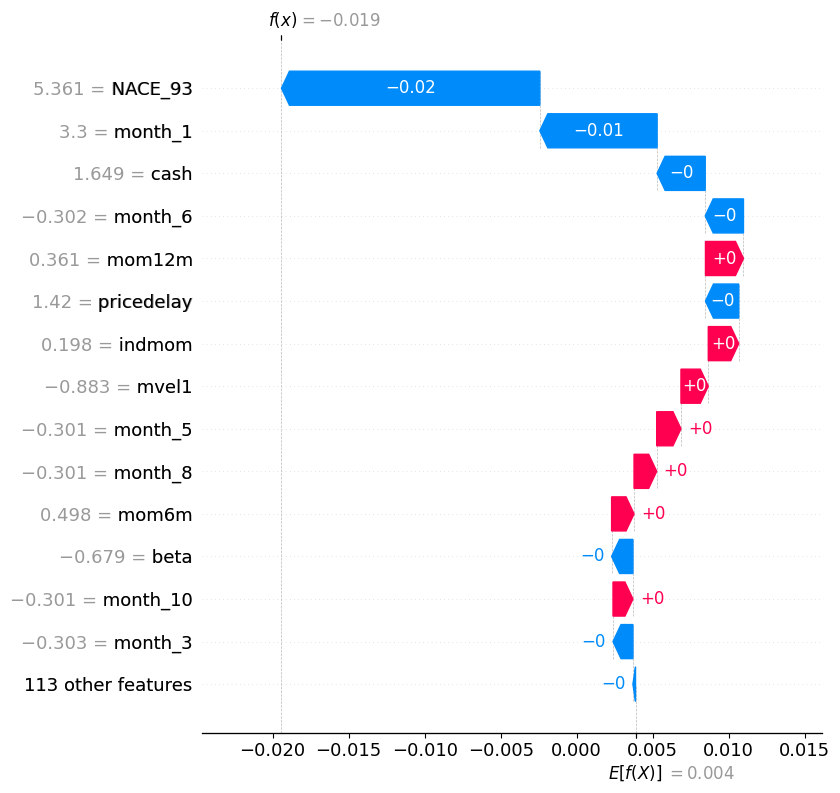

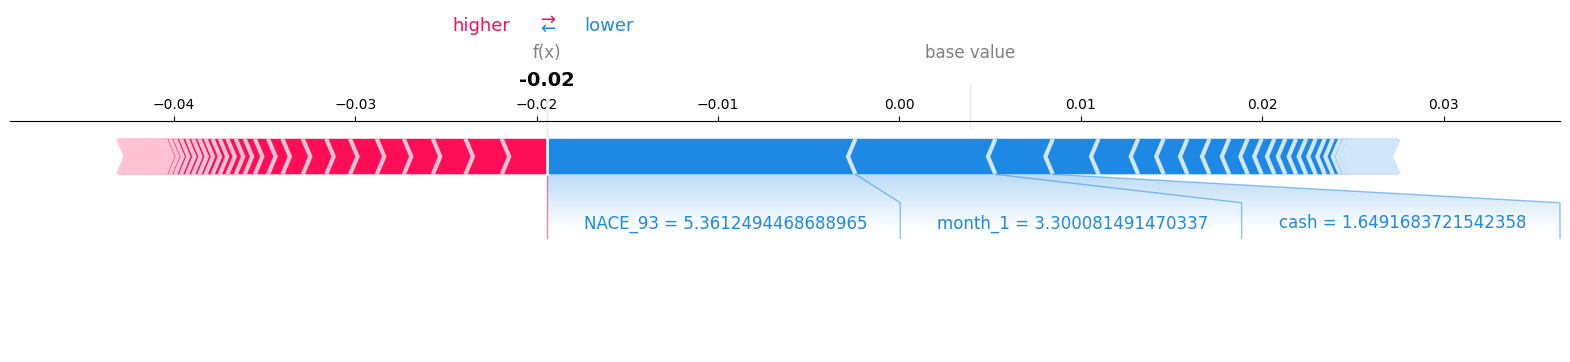

In [ ]:
# 1) Compute the base value manually
with torch.no_grad():
    preds = model(background)
    preds_flat = preds.view(preds.shape[0], -1).mean(dim=1)
    base_val = preds_flat.mean().item()

# 2) Wrap full SHAP matrix for global beeswarm
exp_all = shap.Explanation(
    values        = raw_shap,                  # (n_val, n_features)
    base_values   = np.repeat(base_val, raw_shap.shape[0]),
    data          = X_val[period],             # numpy array or DataFrame
    feature_names = feature_cols,
)
shap.initjs()  # for interactive JS plots in notebooks
shap.plots.beeswarm(exp_all, max_display=20, show=True)

# 3) Select a single sample for local plots
idx     = 0  # or choose by pred magnitude, error, etc.
shap_i  = raw_shap[idx]                        # (n_features,)
x_i     = X_val[period][idx]                   # feature vector

exp_single = shap.Explanation(
    values        = shap_i,
    base_values   = base_val,
    data          = x_i,
    feature_names = feature_cols,
)

# 3a) Waterfall chart
shap.plots.waterfall(exp_single, max_display=15, show=True)

# 3b) Force plot (static PNG version)
shap.force_plot(
    base_val,
    shap_i,
    x_i,
    feature_names=feature_cols,
    matplotlib=True
)
plt.show()


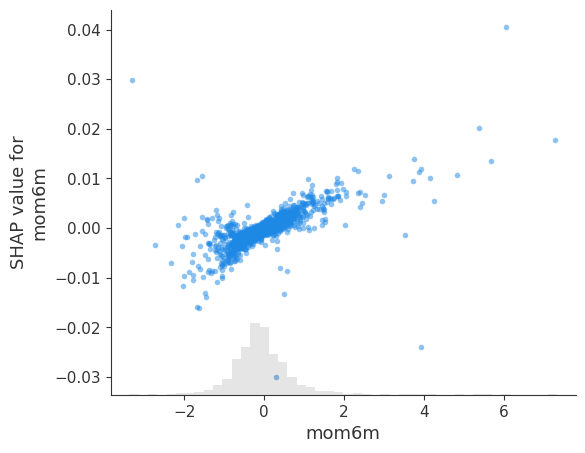

In [140]:
feature_name = "mom6m"  # or any other feature name
shap.plots.scatter(
    exp_all[:, feature_name],    # e.g. exp_all[:, "age"]
    # color=exp_all[:, "age"],     # color by itself or by another feature
    alpha=0.5,
    show=True
)
# shap.dependence_plot(
#     "age",                       # feature to plot
#     raw_shap,                    # your (n_val, n_feat) array
#     X_val[period],               # the validation data
#     feature_names=feature_cols,
#     interaction_index=None,      # or another column name for coloring
#     show=True
# )


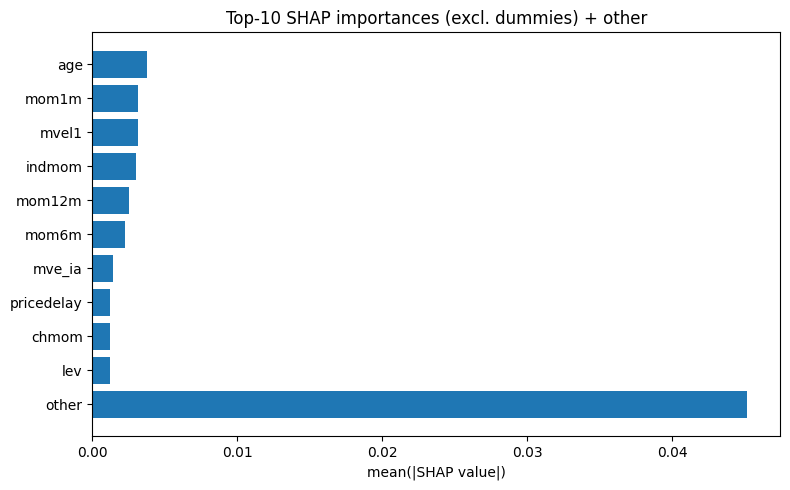

In [ ]:
# --- build the df_imp as before ---
df_imp = pd.DataFrame({
    "feature": feature_cols,
    "shap_importance": global_shap
})

# --- define “dummy” patterns to exclude ---
dummy_prefixes = ("month_", "NACE_")
is_dummy = df_imp["feature"].str.startswith(dummy_prefixes)

# --- pick top-10 *non-dummy* features ---
top_n = 10
df_top_non_dummy = df_imp[~is_dummy].nlargest(top_n, "shap_importance")

# --- compute the “other” bucket as everything *not* in df_top_non_dummy ---
sum_all   = df_imp["shap_importance"].sum()
sum_top   = df_top_non_dummy["shap_importance"].sum()
other_sum = sum_all - sum_top

# --- assemble the final plotting frame using concat ---
df_other = pd.DataFrame([{"feature": "other", "shap_importance": other_sum}])
df_plot  = pd.concat([df_top_non_dummy, df_other], ignore_index=True)

# --- bar chart ---
fig, ax = plt.subplots(figsize=(8,5))
y_pos = np.arange(len(df_plot))
ax.barh(y_pos, df_plot["shap_importance"])
ax.set_yticks(y_pos)
ax.set_yticklabels(df_plot["feature"])
ax.invert_yaxis()
ax.set_xlabel("mean(|SHAP value|)")
ax.set_title(f"Top-{top_n} SHAP importances (excl. dummies) + other")
plt.tight_layout()
plt.show()


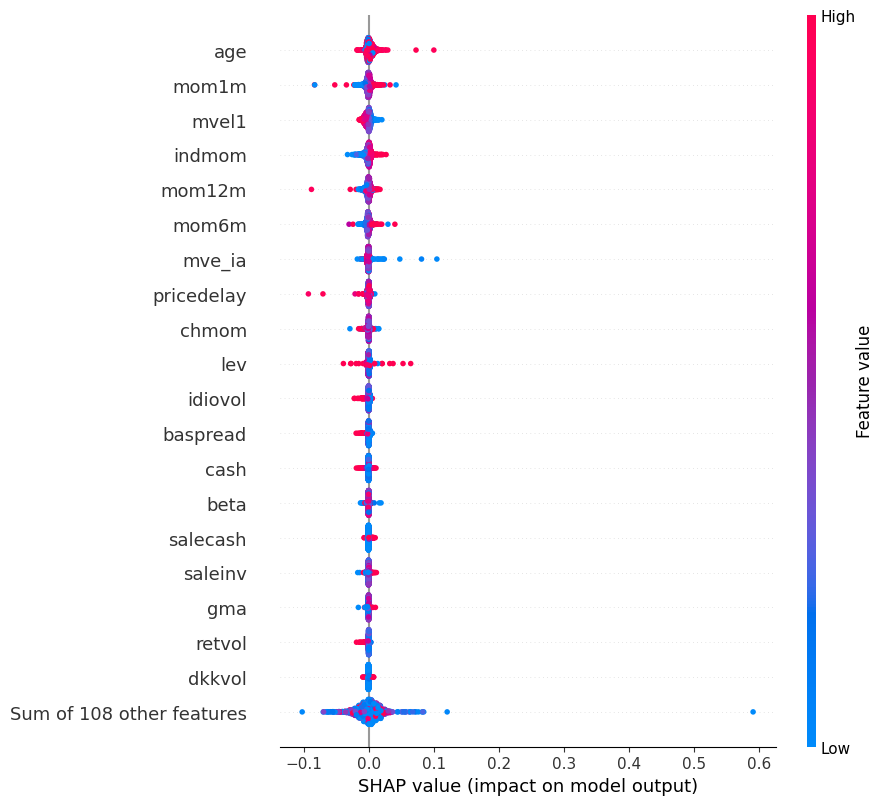

In [ ]:
# full Explanation object (as before)
exp_all = shap.Explanation(
    values        = raw_shap,                     # (n_val, n_feat)
    base_values   = np.repeat(base_val, raw_shap.shape[0]),
    data          = X_val[period],
    feature_names = feature_cols,
)

# 1) compute mean-abs importance & initial sort  
mean_abs    = np.abs(raw_shap).mean(axis=0)
sorted_idx  = np.argsort(mean_abs)[::-1]

# 2) split into non-dummy vs. dummy  
dummy_idx = [i for i,name in enumerate(feature_cols)
             if name.startswith(dummy_prefixes)]
non_dummy = [i for i in sorted_idx if i not in dummy_idx]

# 3) final order: all non-dummies first, then all dummies  
order = non_dummy + dummy_idx

# 4) beeswarm (dummies forced into “other” bucket)
shap.initjs()   # if you want interactive JS in notebooks
shap.plots.beeswarm(
    exp_all,
    max_display=20,
    order=order,
    show=True
)


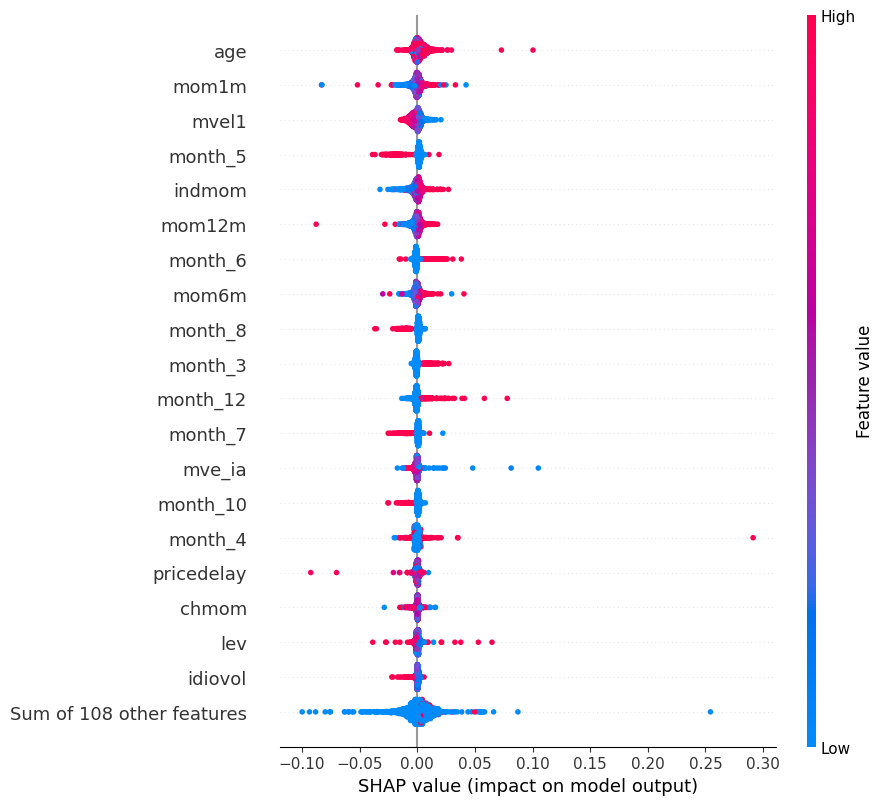

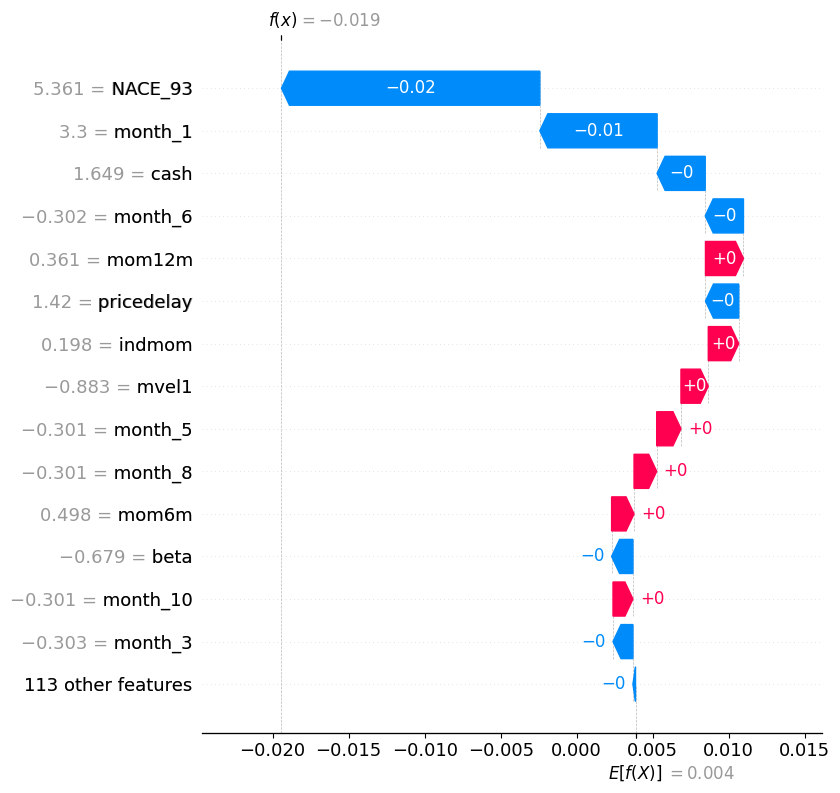

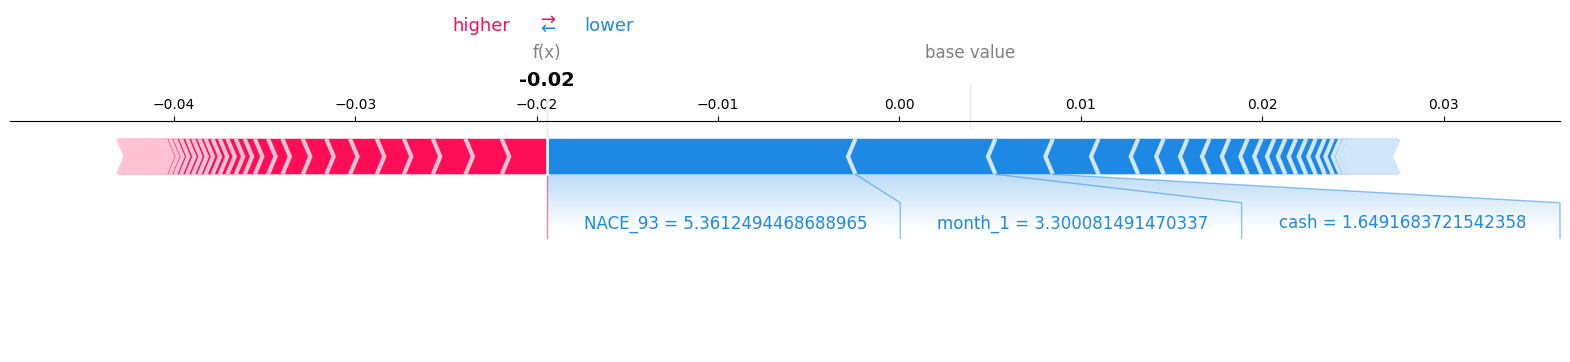

In [ ]:
# # If you want the interactive javascript force plots in notebooks
# # (optional – matplotlib=True gives a static figure instead)
# shap.initjs()

# # -------------------------------------------------
# # 1) Beeswarm (global) – every validation example
# # -------------------------------------------------
# # base_val = (
# #     explainer.expected_value[0]
# #     if isinstance(explainer.expected_value, (list, np.ndarray))
# #     else explainer.expected_value
# # )

# raw_shap = np.squeeze(raw_shap)  

# # print("shap array shape now:", raw_shap.shape)
# # should be (n_val, n_features)

# # 2) COMPUTE BASE VALUE MANUALLY
# with torch.no_grad():
#     bg_preds = model(background).cpu().numpy()     # (bg_size,) or (bg_size,1)
# base_value = np.mean(bg_preds, axis=0)
# # if it’s still an array of length 1, grab the scalar
# if isinstance(base_value, np.ndarray) and base_value.size == 1:
#     base_val = base_value.item()

# # Build a full Explanation object (new SHAP API)
# exp_all = shap.Explanation(
#     values        = raw_shap,                 # shape (n_val, n_features)
#     base_values   = np.repeat(base_val, raw_shap.shape[0]),
#     data          = X_val[period],           # ndarray with feature data
#     feature_names = feature_cols,
# )

# shap.plots.beeswarm(exp_all, max_display=20, show=True)



# # -----------------------------------------------------------------
# # 2) Choose one instance to inspect locally (waterfall & force)
# # -----------------------------------------------------------------
# # Example strategy: pick the sample with the largest |prediction|
# # y_val_pred = model(X_val_t).detach().cpu().numpy().reshape(-1)
# # idx = np.argmax(np.abs(y_val_pred))
# idx = 0                    # <-- or set manually

# x_i        = X_val[period][idx]
# shap_i     = raw_shap[idx]                    # SHAP values  (n_features,)
# exp_single = shap.Explanation(
#     values        = shap_i,
#     base_values   = base_val,
#     data          = x_i,
#     feature_names = feature_cols,
# )

# # -------- waterfall (step-by-step contribution chart)
# shap.plots.waterfall(exp_single, max_display=15, show=True)



# # -------- force plot (same sample – push / pull visual)
# # NB:  • set matplotlib=True for a static PNG (works everywhere)
# #      • omit it for an interactive JS plot inside Jupyter
# shap.force_plot(
#     base_val,
#     shap_i,
#     x_i,
#     feature_names=feature_cols,
#     matplotlib=True,    # change to False for interactive JS if desired
# )
# plt.show()


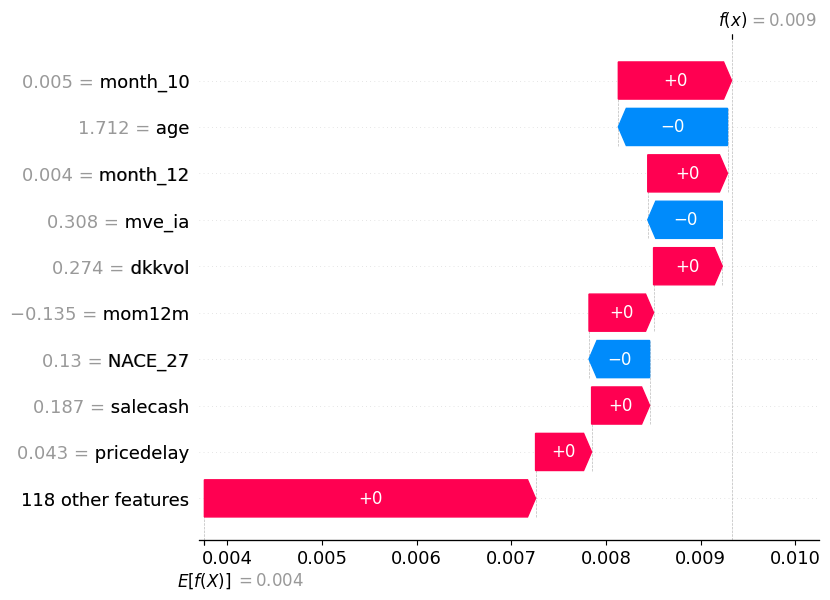

In [ ]:
# np.random.seed(42)
# torch.manual_seed(42)
# # # --- pick your background (same as you passed to the explainer) ---
# # bg_size    = X_tr_t.shape[0]
# # bg_idx     = torch.randperm(X_tr_t.shape[0], device=device)[:bg_size]
# # background = X_tr_t # [bg_idx]     # (bg_size, D)

# # --- manually compute the “base value” as the mean model output on bg ---
# model.eval()
# with torch.no_grad():
#     base_value = model(background).mean().item()

# # --- now get SHAP values for your single “mean” input ---
# mean_input = X_val_t.mean(dim=0, keepdim=True)   # shape (1, D)
# raw        = explainer.shap_values(mean_input)
# sv         = raw[0] if isinstance(raw, list) else raw       # (1, D)
# vals       = sv[0]                                          # 1-D vector

# # --- JS force-plot (interactive) ---
# shap.initjs()
# shap.force_plot(
#     base_value,
#     vals.flatten(),
#     mean_input.cpu().numpy()[0],
#     feature_names=feature_cols
# )

# # --- static waterfall if you prefer matplotlib ---
# shap.waterfall_plot(
#     shap.Explanation(
#         values      = vals.flatten(),
#         base_values = base_value,
#         data        = mean_input.cpu().numpy()[0],
#         feature_names=feature_cols
#     )
# )


Shapley Value Sampling attribution:   0%|          | 0/127001 [00:00<?, ?it/s]

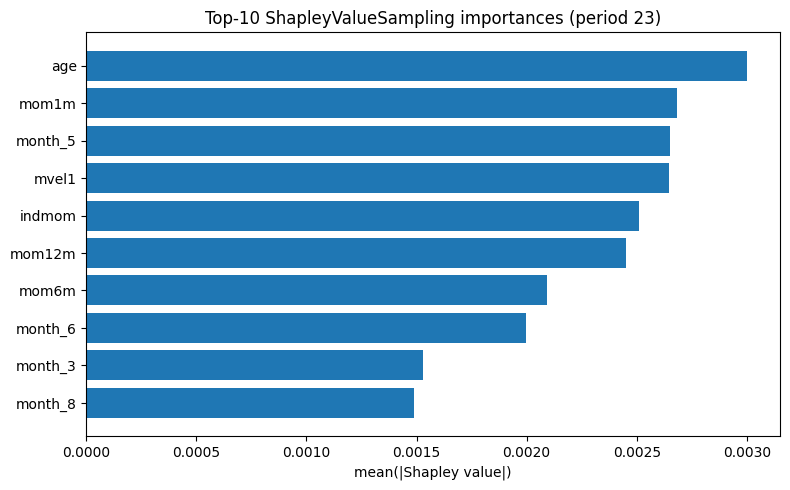

In [107]:
# --- CONFIG & RELOAD ---
period = "23"
device = torch.device('cpu')

load_path = (
    f"models/mlp_y{period}"
    f"_l1{lambda_l1}"
    f"_l2{weight_decay}"
    f"_drop{dropout}"
    f"_lr{learning_rate}"
    f"_w{hidden_width}"
    f"_d{hidden_depth}.pth"
)
model = MLPModel(
    input_dim  = X_train[period].shape[1],
    depth      = hidden_depth,
    width      = hidden_width,
    dropout    = dropout,
    activation = activation_fun,
).to(device)
model.load_state_dict(torch.load(load_path, map_location=device))
model.eval()

# --- DATA TENSORS ---
X_tr_t  = torch.tensor(X_train[period], dtype=torch.float32, device=device)
X_val_t = torch.tensor(X_val[period],   dtype=torch.float32, device=device)

# --- Captum ShapleyValueSampling ---

# 1) Define a forward function returning a scalar per example
def forward_fn(x):
    return model(x).squeeze(-1)

# pick a single reference — e.g. the mean of your training set
baseline = X_tr_t.mean(dim=0, keepdim=True)   # shape (1, n_features)

svs = ShapleyValueSampling(forward_fn)
attr = svs.attribute(
    X_val_t,
    baselines=baseline,      # now (1, n_features), broadcast to (n_val, n_features)
    n_samples=1000,
    perturbations_per_eval=1,
    show_progress=True
)

# --- Aggregate & Plot Top-10 ---
global_attr = attr.abs().mean(dim=0).cpu().numpy()

df_imp = pd.DataFrame({
    "feature": feature_cols,
    "shapley_importance": global_attr
})
df_top10 = df_imp.nlargest(10, "shapley_importance").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,5))
y_pos = np.arange(len(df_top10))
ax.barh(y_pos, df_top10["shapley_importance"])
ax.set_yticks(y_pos)
ax.set_yticklabels(df_top10["feature"])
ax.invert_yaxis()
ax.set_xlabel("mean(|Shapley value|)")
ax.set_title(f"Top-10 ShapleyValueSampling importances (period {period})")
plt.tight_layout()
plt.show()


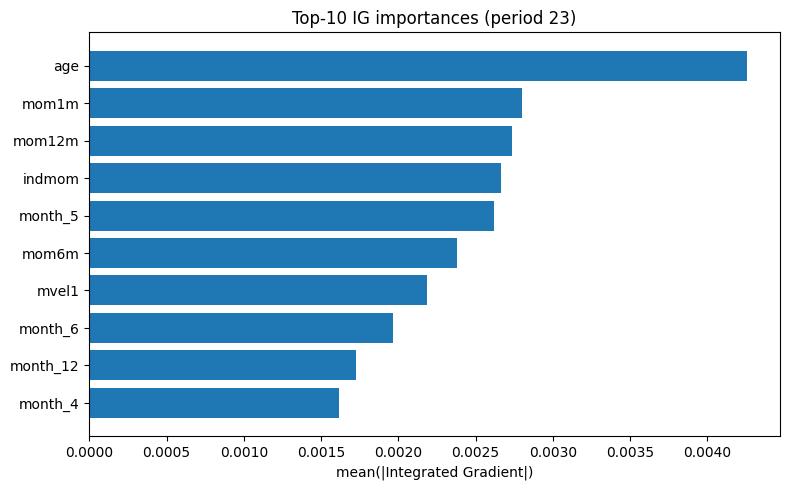

In [ ]:
# ig = IntegratedGradients(model)
# # baseline = zeros (same shape as input)
# baseline = torch.zeros_like(X_val_t)

# # get attributions: shape (n_val, n_features)
# ig_attr = ig.attribute(X_val_t, baselines=baseline, target=None)

# # global importances
# global_ig = ig_attr.abs().mean(dim=0).cpu().numpy()

# # top-10 plot
# df_ig = pd.DataFrame({
#     "feature": feature_cols,
#     "ig_importance": global_ig
# })
# df_ig_top10 = df_ig.nlargest(10, "ig_importance").reset_index(drop=True)

# fig, ax = plt.subplots(figsize=(8,5))
# y_pos = np.arange(len(df_ig_top10))
# ax.barh(y_pos, df_ig_top10["ig_importance"])
# ax.set_yticks(y_pos)
# ax.set_yticklabels(df_ig_top10["feature"])
# ax.invert_yaxis()
# ax.set_xlabel("mean(|Integrated Gradient|)")
# ax.set_title(f"Top-10 IG importances (period {period})")
# plt.tight_layout()
# plt.show()

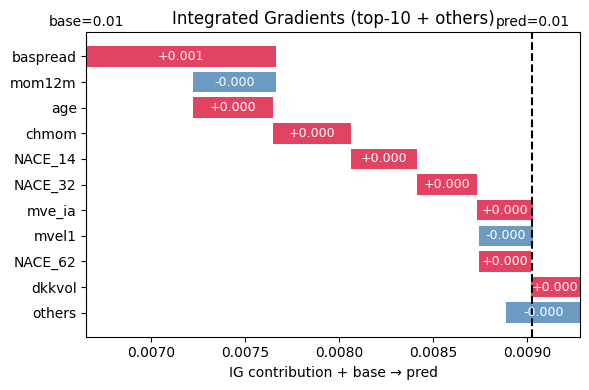

In [ ]:
# # 0) same mean input
# mean_in   = X_val_t.mean(dim=0, keepdim=True)            # (1, D)
# baseline  = torch.zeros_like(mean_in)                    # your chosen baseline

# # 1) IG attributions
# ig = IntegratedGradients(model)
# attr = ig.attribute(mean_in, baselines=baseline)         # (1, D)
# iv  = attr.detach().cpu().numpy().flatten()              # (D,)

# # 2) base / pred
# base_val = float(model(baseline).item())
# pred_val = float(model(mean_in).item())

# # 3) pick top-10 + others
# abs_iv    = np.abs(iv)
# idx_sort  = np.argsort(abs_iv)[::-1]
# top10_idx = idx_sort[:10]
# others_idx= idx_sort[10:]

# names     = [feature_cols[i] for i in top10_idx] + ["others"]
# vals      = np.concatenate([iv[top10_idx], [iv[others_idx].sum()]])

# # 4) waterfall
# fig, ax = plt.subplots(figsize=(6,4))
# cum = base_val
# for i, (nm, v) in enumerate(zip(names, vals)):
#     ax.barh(i, v, left=cum,
#             color="crimson" if v>=0 else "steelblue",
#             alpha=0.8)
#     ax.text(cum + v/2, i, f"{v:+.3f}",
#             va="center", ha="center", color="white", fontsize=9)
#     cum += v

# ax.axvline(base_val, linestyle="--", color="gray")
# ax.text(base_val, -1.2, f"base={base_val:.2f}", ha="center")
# ax.axvline(pred_val, linestyle="--", color="black")
# ax.text(pred_val, -1.2, f"pred={pred_val:.2f}", ha="center")

# ax.set_yticks(range(len(names)))
# ax.set_yticklabels(names)
# ax.invert_yaxis()
# ax.set_xlabel("IG contribution + base → pred")
# ax.set_title("Integrated Gradients (top-10 + others)")
# plt.tight_layout()
# plt.show()


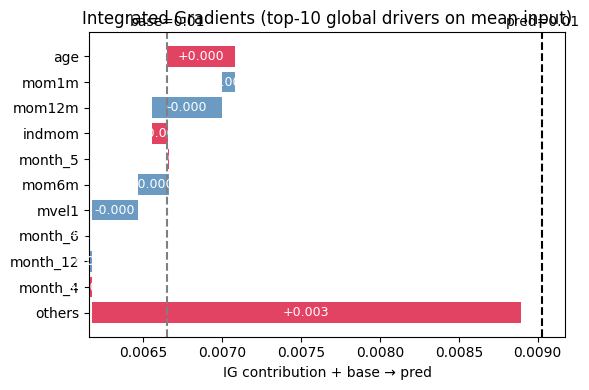

In [ ]:
# from captum.attr import IntegratedGradients
# import numpy as np, matplotlib.pyplot as plt

# # 0) your tensors & model are already on `device`
# #    X_val_t: (N_val, D),  model,  feature_cols (length D)

# # compute global IG exactly as before
# ig          = IntegratedGradients(model)
# baseline    = torch.zeros_like(X_val_t[:1])        # single‐row zeros, same D
# ig_all      = ig.attribute(X_val_t, baselines=baseline)  # (N_val, D)
# global_ig   = ig_all.abs().mean(dim=0).cpu().numpy()     # (D,)

# # find top-10 by absolute global importance
# idx_sort    = np.argsort(global_ig)[::-1]
# top10_idx   = idx_sort[:10]
# others_idx  = idx_sort[10:]

# # now compute the local contributions for the same “mean input”
# mean_in     = X_val_t.mean(dim=0, keepdim=True)    # (1, D)
# attr_mean   = ig.attribute(mean_in, baselines=baseline)  # (1, D)
# loc_vals    = attr_mean.detach().cpu().numpy().flatten() # (D,)

# # assemble names & vals arrays for waterfall
# names  = [feature_cols[i] for i in top10_idx] + ["others"]
# vals   = np.concatenate([
#             loc_vals[top10_idx], 
#             [loc_vals[others_idx].sum()]
#          ])
# base   = float(model(baseline).item())
# pred   = float(model(mean_in).item())

# # plot
# fig, ax = plt.subplots(figsize=(6,4))
# cum = base
# for i, (nm, v) in enumerate(zip(names, vals)):
#     ax.barh(i, v, left=cum,
#             color="crimson" if v>=0 else "steelblue", alpha=0.8)
#     ax.text(cum + v/2, i, f"{v:+.3f}",
#             va="center", ha="center", color="white", fontsize=9)
#     cum += v

# # annotate
# ax.axvline(base, linestyle="--", color="gray")
# ax.text(base, -1.2, f"base={base:.2f}", ha="center")
# ax.axvline(pred, linestyle="--", color="black")
# ax.text(pred, -1.2, f"pred={pred:.2f}", ha="center")

# ax.set_yticks(range(len(names)))
# ax.set_yticklabels(names)
# ax.invert_yaxis()
# ax.set_xlabel("IG contribution + base → pred")
# ax.set_title("Integrated Gradients (top-10 global drivers on mean input)")
# plt.tight_layout()
# plt.show()


In [11]:
# # 1) pick your single instance
# mean_input = X_val_t.mean(dim=0, keepdim=True)    # (1, D)
# mean_np    = mean_input.cpu().numpy()

# # 2) re-instantiate your GradientExplainer
# shap_explainer = shap.GradientExplainer(model, background)

# # 3) get shap values for that one row
# raw = shap_explainer.shap_values(mean_input)     
# # raw is either an array (1,D) or [ array(1,D) ]; unwrap:
# sv = raw[0] if isinstance(raw, list) else raw
# base_value = shap_explainer.expected_value  # float or array([float])

# # 4) visualize in-line
# shap.initjs()
# # force_plot shows a horizontal “waterfall” of contributions
# shap.force_plot(
#     base_value,                       # base prediction
#     sv[0],                            # contributions for sample 0
#     mean_np[0],                       # feature values
#     feature_names=feature_cols,
#     matplotlib=True                   # use matplotlib backend
# )

# # 5) if you prefer the static waterfall chart
# shap.waterfall_plot(
#     shap.Explanation(
#       values=sv[0],
#       base_values=base_value,
#       data=mean_np[0],
#       feature_names=feature_cols
#     )
# )


In [104]:
# # 1) compute IG on the same mean input
# ig = IntegratedGradients(model)
# baseline   = torch.zeros_like(mean_input)      # your chosen baseline
# ig_attr    = ig.attribute(mean_input, baselines=baseline, n_steps=200, target=None)
# ig_vals    = ig_attr.detach().cpu().numpy().flatten()   # shape (D,)

# # 2) compute base & pred for that input
# base_val = model(baseline).item()
# pred_val = model(mean_input).item()
# assert np.isclose(base_val + ig_vals.sum(), pred_val, atol=1e-5)

# # 3) build a DataFrame and sort by signed contribution
# import pandas as pd
# df = pd.DataFrame({
#     "feature": feature_cols,
#     "contrib": ig_vals
# }).sort_values("contrib")

# # 4) plot a waterfall
# cum = base_val
# fig, ax = plt.subplots(figsize=(6,4))
# for xi, (feat, val) in enumerate(zip(df["feature"], df["contrib"])):
#     ax.barh(
#         y=xi, width=val,
#         left=cum,
#         color="crimson" if val>0 else "steelblue",
#         alpha=0.8
#     )
#     ax.text(cum + val/2, xi, f"{val:+.3f}", va="center", ha="center", color="white")
#     cum += val

# # annotate base & final
# ax.axvline(base_val, linestyle="--", color="gray")
# ax.text(base_val, -1, f"base={base_val:.2f}", ha="center")
# ax.axvline(pred_val, linestyle="--", color="black")
# ax.text(pred_val, -1, f"pred={pred_val:.2f}", ha="center")
# ax.set_yticks(range(len(df)))
# ax.set_yticklabels(df["feature"])
# ax.invert_yaxis()
# ax.set_xlabel("Attribution + base → prediction")
# ax.set_title("Integrated Gradients Waterfall (mean input)")
# plt.tight_layout()
# plt.show()


In [ ]:
# # ===========================================================
# # 0.  EXTRA IMPORTS
# # ===========================================================
# import statsmodels.api as sm
# from sklearn.base import BaseEstimator, RegressorMixin
# from sklearn.inspection import PartialDependenceDisplay
# from scipy.stats import spearmanr
# import textwrap
# import matplotlib.pyplot as plt
# from pathlib import Path

# pdp_dir   = Path("plots/pdp")
# pdp_dir.mkdir(parents=True, exist_ok=True)

# # -----------------------------------------------------------
# # 1.  Wrapper so sklearn's PDP can call a PyTorch model
# # -----------------------------------------------------------
# class TorchRegressor(BaseEstimator, RegressorMixin):
#     """Minimal sklearn-compatible wrapper around a trained torch model."""
#     def __init__(self, model, device=device):
#         self.model  = model.eval().to(device)
#         self.device = device

#     def predict(self, X):
#         with torch.no_grad():
#             X_t = torch.tensor(X, dtype=torch.float32, device=self.device)
#             return self.model(X_t).cpu().numpy().ravel()


# # -----------------------------------------------------------
# # 2.  Produce partial-dependence plots
# # -----------------------------------------------------------
# TOP_K = 3            # number of variables per year

# for yr in periods.keys():
#     print(f"PDPs for {yr} …")

#     # 2.1  rank features by SHAP (already computed)
#     df_year = importance_df[importance_df["year"] == yr]
#     top_idx = df_year["shap"].abs().nlargest(TOP_K).index
#     feat_idx = [feature_cols.index(f) for f in df_year.loc[top_idx, "feature"]]

#     # 2.2  build sklearn wrapper & run PDP
#     torch_est = TorchRegressor(best_models[yr])

#     fig, ax = plt.subplots(nrows=TOP_K, figsize=(6, 2.8*TOP_K), sharex=False)
#     PartialDependenceDisplay.from_estimator(
#         torch_est,
#         X_val[yr],                            # **scaled** inputs
#         features=feat_idx,
#         feature_names=feature_cols,
#         ax=ax
#     )
#     fig.suptitle(f"Partial-dependence (top-{TOP_K} SHAP variables) – {yr}",
#                  fontsize=12)
#     plt.tight_layout()
#     fig.savefig(pdp_dir / f"pdp_{yr}.png", dpi=300, bbox_inches="tight")
#     plt.close()


# # -----------------------------------------------------------
# # 3.  Collect OLS importances
# #     (absolute, standardised β – comparable scale)
# # -----------------------------------------------------------
# ols_rows = []
# for yr in periods.keys():
#     X_std = X_train[yr]                     # already StandardScaler-ed
#     X_ols = sm.add_constant(X_std)          # add intercept
#     y_ols = y_train[yr].ravel()

#     ols_mod = sm.OLS(y_ols, X_ols).fit()
#     beta    = ols_mod.params[1:]            # drop intercept
#     ols_rows.append(np.abs(beta).values)

# abs_beta_df = pd.DataFrame(ols_rows, columns=feature_cols,
#                            index=periods.keys()).reset_index().melt(
#                            id_vars="index", var_name="feature",
#                            value_name="ols")
# abs_beta_df.rename(columns={"index": "year"}, inplace=True)

# # -----------------------------------------------------------
# # 4.  Merge (OLS | SHAP | IG) & compute ranks / correlations
# # -----------------------------------------------------------
# merged = importance_df.merge(abs_beta_df, on=["year", "feature"])
# # optional: Spearman rank correlation diagnostics
# for yr in periods.keys():
#     sub = merged[merged.year == yr]
#     rho_s, _ = spearmanr(sub["shap"], sub["ig"])
#     print(f"Year {yr}: Spearman ρ(SHAP, IG) = {rho_s:.2f}")

# # pick the SAME top-K per year (by SHAP) to go in the table
# table_rows = []
# for yr in periods.keys():
#     sub = merged[merged.year == yr]
#     top = sub.nlargest(TOP_K, "shap")
#     table_rows.append(top.assign(rank=range(1, TOP_K+1)))

# table_df = pd.concat(table_rows)

# # -----------------------------------------------------------
# # 5.  Build LaTeX table in your preferred style
# # -----------------------------------------------------------
# def format_float(x):
#     return f"{x:0.4f}"

# latex_lines = []

# header = textwrap.dedent(r"""
# \begin{tabular}{cclccc}
# \hline\hline \\ [-1.8ex]
#  &  &  & OLS & SHAP & IG \\ 
# \hline 
# """)
# latex_lines.append(header)

# for yr in periods.keys():
#     sub = table_df[table_df.year == yr].sort_values("rank")
#     first = True
#     for _, r in sub.iterrows():
#         latex_lines.append(
#             (r"\multirow[c]{%d}{*}{\rotatebox{90}{%s}} & %s & %s & %s & %s \\" %
#              (TOP_K if first else 0,
#               yr if first else "",
#               r["feature"],
#               format_float(r["ols"]),
#               format_float(r["shap"]),
#               format_float(r["ig"])))
#         )
#         first = False
#     latex_lines.append(r"\cline{2-6}")

# footer = textwrap.dedent(r"""
# \hline
# \hline
# \end{tabular}
# """)
# latex_lines.append(footer)

# latex_table = "\n".join(latex_lines)

# # save to file
# with open("var_importance_table.tex", "w") as f:
#     f.write(latex_table)

# print("LaTeX table saved to var_importance_table.tex")
# print("\n--- preview ---\n")
# print(latex_table)


# Test hyperparameters

In [ ]:
# current runtime: 4h 35m
# training model with most data on multiple parameters
weight_decay_space = [1e-3, 5e-3] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [0.0, 0.2] # np.geomspace(0.0, 0.3, num=4)
l1_space = [1e-4, 1e-3]
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
depth_space = [1, 2, 4, 8]
width_space = [16, 32, 64, 128, 256]

best_models_23 = {}
history_23 = {}
models_23 = {}
year = '23'

for weight_decay in weight_decay_space:
    for dropout in dropout_space:
        for lambda_l1 in l1_space:
            for learning_rate in learning_rate_space:
                for hidden_depth in depth_space:
                    for hidden_width in width_space:
                        np.random.seed(42)
                        torch.manual_seed(42)
                        print(f"Training model for year '{year} with weight_decay={weight_decay}, dropout={dropout}, learning_rate={learning_rate}, hidden_depth={hidden_depth}, hidden_width={hidden_width}...")
                        # Initialize the model
                        input_dim = X_train[year].shape[1]
                        name = f'l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        models_23[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                        optimizer = torch.optim.AdamW(models_23[name].parameters(), weight_decay=weight_decay, lr=learning_rate)
                        train = MLPdataset(X_train[year], y_train[year])
                        val = MLPdataset(X_val[year], y_val[year])
                        best_models_23[name], history_23[name] = train_mlp(train,          
                                                        val,
                                                        models_23[name],
                                                        criterion,
                                                        epochs,
                                                        patience,
                                                        print_freq,
                                                        device,
                                                        optimizer,
                                                        lambda_l1=lambda_l1,
                                                        lambda_l2=lambda_l2,
                                                        batch_size=batch_size,
                                                        shuffle_train=True,
                                                        shuffle_val=False,
                                                        save_path=f'models/mlp_y23_l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                        )

Training model for year '23 with weight_decay=0.0001, dropout=0.0, learning_rate=0.0003, hidden_depth=1, hidden_width=32...
Epoch 250/500  - Train Loss: 2.41825E-02  - Val Loss: 1.86840E-02
Early stopping at epoch 276
Best val loss: 1.55034E-02
Model saved to models/mlp_y23_l10.0_l20.0001_drop0.0_lr0.0003_w32_d1.pth
Training model for year '23 with weight_decay=0.0001, dropout=0.0, learning_rate=0.0003, hidden_depth=1, hidden_width=64...
Epoch 250/500  - Train Loss: 2.26286E-02  - Val Loss: 1.99727E-02
Early stopping at epoch 278
Best val loss: 1.66661E-02
Model saved to models/mlp_y23_l10.0_l20.0001_drop0.0_lr0.0003_w64_d1.pth
Training model for year '23 with weight_decay=0.0001, dropout=0.0, learning_rate=0.0003, hidden_depth=1, hidden_width=128...
Epoch 250/500  - Train Loss: 2.06371E-02  - Val Loss: 1.82761E-02
Early stopping at epoch 297
Best val loss: 1.43564E-02
Model saved to models/mlp_y23_l10.0_l20.0001_drop0.0_lr0.0003_w128_d1.pth
Training model for year '23 with weight_deca